In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import random
import nibabel as nib
import torch
import time
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.transforms as transforms 
from torch.utils.tensorboard import SummaryWriter
import SimpleITK as sitk

In [8]:
class VolumeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.volume_files = [
            os.path.join(dirpath, f)
            for dirpath, _, filenames in os.walk(root_dir)
            if "20" in dirpath and "80" not in dirpath
            for f in filenames
            if f.endswith('.mhd')
        ]

    def __len__(self):
        return len(self.volume_files)

    def __getitem__(self, idx):
        volume_path = self.volume_files[idx]
        
        # Load the volume based on file extension
        if volume_path.endswith(('.nii', '.nii.gz')):
            volume = nib.load(volume_path).get_fdata()
        elif volume_path.endswith('.mhd'):
            sitk_image = sitk.ReadImage(volume_path)
            volume = sitk.GetArrayFromImage(sitk_image)  # Convert to a NumPy array
        else:
            raise ValueError(f"Unsupported file type: {volume_path}")
        
        # Convert to PyTorch tensor and normalize
        volume = torch.from_numpy(volume).float().unsqueeze(0)
        volume = (volume - volume.min()) / (volume.max() - volume.min())

        # Apply any optional transformations
        if self.transform:
            volume = self.transform(volume)

        return volume



In [9]:
def random_crop(volume, crop_size):
    w, h, d = volume.shape[1:]
    th, tw, td = crop_size
    
    if w == th and h == tw and d == td:
        return volume

    x1 = torch.randint(0, w - th + 1, (1,))
    y1 = torch.randint(0, h - tw + 1, (1,))
    z1 = torch.randint(0, d - td + 1, (1,))

    cropped_volume = volume[:, x1:x1+th, y1:y1+tw, z1:z1+td]

    # Pad if necessary to maintain original size
    pad_left = max(0, -x1)
    pad_right = max(0, x1 + th - w)
    pad_top = max(0, -y1)
    pad_bottom = max(0, y1 + tw - h)
    pad_front = max(0, -z1)
    pad_back = max(0, z1 + td - d)

    cropped_volume = torch.nn.functional.pad(cropped_volume, (pad_left, pad_right, pad_top, pad_bottom, pad_front, pad_back))

    return cropped_volume

In [10]:
transform = transforms.Compose([
    transforms.Lambda(lambda x: F.interpolate(x.unsqueeze(0), size=(128, 128, 128), mode='trilinear', align_corners=False).squeeze(0)),
    transforms.Lambda(lambda x: random_crop(x, crop_size=(128, 128, 128))),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),

])

In [11]:
root_dir = "raw"


dataset = VolumeDataset(root_dir=root_dir, transform=transform)

In [12]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

Train size: 6, Validation size: 0, Test size: 2


In [13]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [14]:
num_train_images = len(train_dataset)
num_val_images = len(val_dataset)
num_test_images = len(test_dataset)

print(f"Number of images in Training set: {num_train_images}")
print(f"Number of images in Validation set: {num_val_images}")
print(f"Number of images in Test set: {num_test_images}")

Number of images in Training set: 6
Number of images in Validation set: 0
Number of images in Test set: 2


In [15]:
num_train_batches = len(train_loader)
num_val_batches = len(val_loader)
num_test_batches = len(test_loader)

print(f"Number of batches in Training set: {num_train_batches}") 
print(f"Number of batches in Validation set: {num_val_batches}")
print(f"Number of batches in Test set: {num_test_batches}")

Number of batches in Training set: 2
Number of batches in Validation set: 0
Number of batches in Test set: 1


In [16]:
class SRCNN3D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv3d(64, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv3d(32, 1, kernel_size=5, padding=2)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        output = self.conv1(x)
        output = F.relu(output)
        output = self.conv2(output)
        output = F.relu(output)
        output = self.dropout(output)
        output = self.conv3(output)
        output += x
        return output

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = SRCNN3D()
model= nn.DataParallel(model)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


cuda


In [18]:
def calculate_metrics(output, target):
    output_np = output.squeeze().cpu().numpy()
    target_np = target.squeeze().cpu().numpy()
    min_dim = min(output_np.shape[-2:])
    if min_dim < 7:
        win_size = min_dim  
        if win_size % 2 == 0: 
            win_size -= 1
    else:
        win_size = 7 

    ssim_value = ssim(output_np, target_np, data_range=target_np.max() - target_np.min(),win_size=win_size)

    mse_value = np.mean((output_np - target_np) ** 2)
    if mse_value == 0:
        psnr_value = float('inf')  
    else:
        psnr_value = psnr(target_np, output_np, data_range=target_np.max() - target_np.min())

    return ssim_value, psnr_value, mse_value


In [19]:


def visualize_images(original, upsampled, output):
    plt.figure(figsize=(12, 4))

    depth = original.shape[1]
    mid_slice = min(depth // 2, original.shape[1] - 1) 
    
    plt.subplot(1, 3, 1)
    plt.imshow(original[:, mid_slice, :, :].cpu().permute(1, 2, 0).numpy(), cmap="gray")
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    depth_upsampled = upsampled.shape[1]
    mid_slice_upsampled = min(depth_upsampled // 2, depth_upsampled - 1)  # Adjusted for upsampled depth
    plt.imshow(upsampled[:, mid_slice_upsampled, :, :].cpu().permute(1, 2, 0).numpy(), cmap="gray")
    plt.title('Upsampled Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    depth_output = output.shape[1]
    mid_slice_output = min(depth_output // 2, depth_output - 1)  # Adjusted for output depth
    plt.imshow(output[:, mid_slice_output, :, :].cpu().permute(1, 2, 0).numpy(), cmap="gray")
    plt.title('Model Output')
    plt.axis('off')
    
    plt.show()




In [ ]:
from tqdm import tqdm
import time

In [ ]:
num_epochs = 100
scale_factor = 0.5
writer = SummaryWriter('runs/SRCNN3D_2')


for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    for i, data in enumerate(tqdm(train_loader,desc = "Training", leave = False)):
        inputs = data.to(device)
        inputs_downsampled = F.interpolate(inputs, scale_factor=scale_factor, mode='trilinear', align_corners=False)
        inputs_upsampled = F.interpolate(inputs_downsampled, size=inputs.shape[2:], mode='trilinear', align_corners=False)
        outputs = model(inputs_upsampled)
        loss = criterion(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        writer.add_scalar('Loss/train', loss.item(), epoch * len(train_loader) + i)

    epoch_time = time.time() - start_time

    writer.add_scalar('Performance/Epoch Time (s)', epoch_time, epoch)



    model.eval()
    ssim_total, psnr_total, mse_total = 0, 0, 0
    selected_images = random.sample(range(len(val_loader.dataset)), k=2) 

    with torch.no_grad():
        val_loss = 0
        for idx in selected_images:
            inputs = val_loader.dataset[idx].unsqueeze(0).to(device)
            inputs_downsampled = F.interpolate(inputs, scale_factor=scale_factor, mode='trilinear', align_corners=False)
            inputs_upsampled = F.interpolate(inputs_downsampled, size=inputs.shape[2:], mode='trilinear', align_corners=False)
            outputs = model(inputs_upsampled)
            ssim_val, psnr_val, mse_val = calculate_metrics(outputs, inputs)
            ssim_total += ssim_val
            psnr_total += psnr_val
            mse_total += mse_val

        
            if (epoch + 1) % 10 == 0:
                torch.save(model.state_dict(), f'model2/SRCNN3D_epoch_{epoch+1}.pth')
                visualize_images(inputs[0], inputs_upsampled[0], outputs[0])


    avg_ssim = ssim_total / len(selected_images)
    avg_psnr = psnr_total / len(selected_images)
    avg_mse = mse_total / len(selected_images)
    writer.add_scalar('SSIM/val', avg_ssim, epoch)
    writer.add_scalar('PSNR/val', avg_psnr, epoch)
    writer.add_scalar('MSE/val', avg_mse, epoch)



    print(f'Validation - Epoch [{epoch + 1}/{num_epochs}], SSIM: {ssim_total / len(selected_images):.4f}, PSNR: {psnr_total / len(selected_images):.4f}, MSE: {mse_total / len(selected_images):.4f}')

writer.close()


RuntimeError: stack expects each tensor to be equal size, but got [1, 206, 206, 154] at entry 0 and [1, 512, 512, 119] at entry 1

/tmp/ipykernel_660410/2513189792.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/SRCNN3D_epoch_100.pth'))


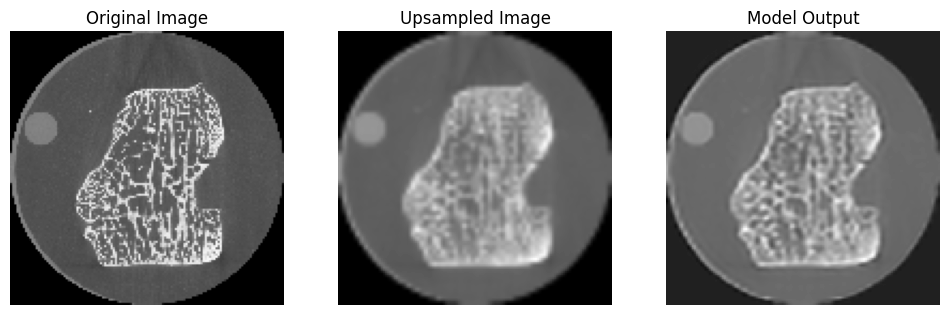

In [20]:
def test_model():
    scale_factor = 0.5
    model.load_state_dict(torch.load('models/SRCNN3D_epoch_100.pth'))  
    model.eval()  

    with torch.no_grad():

        for i, data in enumerate(test_loader):
            if i >= 20:
                break
            inputs = data.to(device)  # Move data to the appropriate device
            inputs_downsampled = F.interpolate(inputs, scale_factor=scale_factor , mode='trilinear', align_corners=False)
            inputs_upsampled = F.interpolate(inputs_downsampled, size=inputs.shape[2:], mode='trilinear', align_corners=False)
            outputs = model(inputs_upsampled)
            outputs_resized = F.interpolate(outputs, size=inputs.shape[2:], mode='trilinear', align_corners=False)

            if i < 10:  # You can change this number to visualize more/less images
                visualize_images(inputs[0], inputs_upsampled[0], outputs_resized[0])
test_model()
